### Устанавливаем библиотеки 




Задача № 3 (для 2 курса)
 
Название: Автоматизация обработки машиночитаемых документов.
 
Описание: Вам будет выдан набор данных документов из системы документооборота небольшой вымышленной компании. На основе этого набора данных вам нужно построить граф знаний о компании, который включает:

● 	Организационную структуру (список подразделений). Есть

● 	Список сотрудников 

●  и их должностей. 

● 	Должностные обязанности и полномочия сотрудников.

На основе построенного графа знаний нужно разработать систему, которая ищет ошибки в проверочных документах (10 правильных документов, 10 документов с ошибками), например:

● 	Опечатки в названиях подразделений или ФИО сотрудников.

● 	Несуществующие подразделения или сотрудники, ошибки в должностях.

● 	Несоответствие тематики документа подразделению, в которое он направлен для исполнения (в бухгалтерию направлен документ с задачей по ИТ).
 
Ссылка на набор данных – https://www.dropbox.com/sh/d5h5f3yrql8x392/AACQ2WYa5qYCqjC8QuVZ5TJ4a?dl=1 

Вам будет передана открытая часть датасета с разметкой, закрытая часть датасета без разметки и проверочные документы (20 документов для подзадачи обнаружения ошибок в документах).
 
Требования к решению:
1.   Код программы построения графа знаний о компании (ссылка на GitHub), с помощью которого можно ответить на вопросы:
a.   Количество отделов.
b.   Количество сотрудников.
c.	К какому отделу относится конкретная задача.
2.   Код программы поиска документов с ошибками на основе графа знаний (ссылка на GitHub).
3.   Документы, в которых найдены ошибки.
 
Критерии оценки:
● 	За каждый найденный документ с ошибкой начисляется 10 баллов.
● 	За каждый документ, представленный как ошибочный, но в котором ошибки на самом деле нет, назначается штраф -1 балл.
 
Советы по реализации:
1.   Извлечь именованные сущности (NER) из текста можно с помощью библиотеки spacy (https://spacy.io/), pullenti, natasha или соответствующих моделей с huggingface (https://huggingface.co/).
2.   Для сущностей, для которых не удастся найти типовые предобученные модели (например, сущность «Задача» или «Департамент») организовать обучение модели с использованием открытой части датасета.
3.   Для построения графа связей в организации рекомендуется использовать библиотеку NetworkX - https://networkx.org/



# Решение.

1. task_text: разбить на предложения. Выявить функционал. FIO_POSITION: ФИО, должность, функционал, отдел (не необходимо).
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.


In [ ]:
#!pip install networkx
#!pip install --upgrade networkx
#!pip install pygraphviz pydot lxml
#!pip install pygraphviz
#!pytest networkx
#!pytest --pyargs networkx
#! pip install pymorphy2
#! pip install -U pip setuptools wheel
#! pip install -U spacy 
#! python -m spacy download en_core_web_sm
#! python -m spacy download ru_core_news_sm
#! pip install --user -U nltk
#! pip install -U liblinear-official
#! pip install natasha
#! pip install ipymarkup
#! pip install transformers sentencepiece sacremoses
#!pip install pymorphy2[fast]
#!pip install natasha spacy==3.3

#!python -m spacy download ru_core_news_sm
#!pip install tensorflow-text spacy==3.3
#!python -m spacy download ru_core_news_sm
#!pip install pymorphy2[fast] 


In [123]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from yargy.tokenizer import MorphTokenizer
from yargy import rule, or_, Parser
from yargy.predicates import eq, type as _t, normalized, gram
from ipymarkup import show_span_box_markup, show_span_line_markup
from yargy.pipelines import morph_pipeline as mp, caseless_pipeline as cp
from yargy.interpretation import fact
from IPython.display import display

from transformers import pipeline, AutoTokenizer, AutoConfig, AutoModelForTokenClassification

# Морфологический анализ
import pymorphy2

# Синтаксический анализ
import spacy
from spacy import displacy

import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
import gensim.models


import requests
import nltk
import spacy
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2

import spacy
from spacy import displacy


import pandas as pd
import json 
import spacy
from spacy.symbols import nsubj, VERB


In [ ]:
directory = 'hackaton_2023_01/task_3/full_dataset/json/'
data = []
for n in range(9999):
    name = str(n) + '.json'
    try:
        with open(directory + name, "r") as readFile:
            jsonData = json.load(readFile)
            jsonData["id"] = n
            data.append(jsonData)
    except ValueError:
        continue

In [ ]:
with open('merged_data.json', "r") as readFile:
            merge_data = json.load(readFile)

### Определяем количество департаментов в компании

In [ ]:
#data

In [ ]:
DEPARTMENTS = []
for n in range(10000):
    try:
        for i in range(1,30):
            DEPARTMENTS.append(data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_groups'])
    except KeyError:
        continue
    except IndexError:
        continue


In [ ]:
FIO_POSITION = []
for n in range(10000):
    try:
        for i in range(1,20):
            FIO_POSITION.append(data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_people'])
    except KeyError:
        continue
    except IndexError:
        continue

In [ ]:
TASK = []
for n in range(10000):
    try:
        for i in range(1,30):
            TASK.append(data[n]['Tasks']['Task{}'.format(i)]['task_text'])
    except KeyError:
        continue
    except IndexError:
        continue

In [ ]:
POSITION = []
for n in range(10000):
    try:
        for i in range(1,30):
            POSITION.append(data[n]['Tasks']['Global_supervisor'][i])
    except KeyError:
        continue
    except IndexError:
        continue

### Очищаем данные

In [ ]:
def text_split(text: str):
    pouch_of_words = []
    for line in text:
        line = line.split()
        pouch_of_words.append(line)
    return pouch_of_words
     

In [ ]:
text_split(FIO_POSITION[:2])

In [ ]:
def token_words_split(text: str):
    pouch_of_words = []
    if type(text) == list:
        for line in text:
            TOKENIZER = word_tokenize(line)
            pouch_of_words.append(TOKENIZER)
        return pouch_of_words

pouch_of_words = token_words_split(FIO_POSITION[:2])
pouch_of_words

In [ ]:
text = FIO_POSITION[:2]
text

In [ ]:
def split_spacy(text: str):
    pouch_of_words = []
    nlp = spacy.load('ru_core_news_sm')
    if type(text) == list:
        for line in text:
            doc = nlp(line)
            for token in doc:
                pouch_of_words.append(token)
    return pouch_of_words


In [ ]:
FIO_POSITION[:2]

In [ ]:
nltk.download('punkt')
def sentence(text: str):
   

    sentences = sent_tokenize(text)
    return sentences
sentence(FIO_POSITION[:1])

### Морфологический анализ

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def morph_word(words: str):
    words = split_spacy(words)
    morph_words = []
    for word in words:
        print(word)

morph_word(POSITION[:1])

### Синтаксический анализ

In [ ]:
#nlp_synt = spacy.load('ru_core_news_sm')

### Разделяем текст на предложения.

In [ ]:
def sentence(text: str):
    pouch_of_sentence = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            nltk.download('punkt')
            sentences = sent_tokenize(line)
            pouch_of_sentence.append(sentences)
    return str(pouch_of_sentence)
    
text = sentence(FIO_POSITION[10:12])

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
 
    Doc
)


In [ ]:
 
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [ ]:
syntax_parser = NewsSyntaxParser(emb)


In [ ]:
doc_n = Doc(text)

In [ ]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [ ]:
#doc_n.parse_syntax(syntax_parser)

In [ ]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [ ]:
#doc_n.sents[0].syntax.print()

### Выявление ФИО

In [ ]:
FIO = []

for tocken in doc_n.tokens:
    if tocken.rel == 'flat:name' or tocken.rel == 'appos':
        if tocken.rel == 'appos':
            surn = tocken.text 
            if surn in FIO:
                pass
            else:
                FIO.append(surn)
        elif tocken.rel == 'flat:name':
            IO = tocken.text + '.'      
            FIO.append(IO)
           


In [ ]:
doc_n.segment(segmenter) 

In [ ]:
doc_n.tag_morph(morph_tagger)

In [ ]:
doc_n.tag_ner(ner_tagger)

In [ ]:
doc_n.parse_syntax(syntax_parser)

In [ ]:
#display(doc_n.tokens[:5])

In [ ]:
display(doc_n.sents)

In [ ]:
#display(doc_n.tokens)

In [ ]:
for span in doc_n.spans:
    span.normalize(morph_vocab)
   

keywords = {_.text: _.normal for _ in doc_n.spans if _.text != _.normal}
print(span)

In [ ]:

keywords


In [ ]:
for token in doc_n.tokens:
    token.lemmatize(morph_vocab)
    
{_.text: _.lemma for _ in doc_n.tokens}

### Создание дистрибутивно-семантической модели.

In [ ]:
#!pip install navec

In [ ]:
#!curl https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
from navec import Navec

In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
#navec['абакумов']

In [ ]:
#!pip install pymorphy2[fast] 

# Решение.

1. task_text: разбить на предложения. Выявить функционал.
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.


### Построение датафрейма

1. Весь текст.
2. Мешок слов.
3.  Классы - отделы компании.

### Структура датафрейма 
1:текст;       2:FIO_POSITION;       3: TASK;       4: FIO;       5: 8 отделов;

### Создание дата фрейма и векторизация слов.

In [ ]:
DEPARTMENTS = set(DEPARTMENTS)
DEPARTMENTS_list = list(DEPARTMENTS)

#### Строим классы

In [ ]:
value = []
for i in range(1,9):
    value.append(i)
DEPARTMENTS_list

In [ ]:
def classes(list: list) -> dict:
    result = {}

    for n in range(8):
        dep = list[n]
        result[dep] = value[n]

    return result

In [ ]:
classes_dep = classes(DEPARTMENTS_list)
classes_dep

In [ ]:
df_classes = pd.DataFrame()
df_classes

In [130]:
df = pd.json_normalize(merge_data)

     

df.set_index('id', inplace=True)
df.sort_index(inplace=True) # сортировка по индексу=id 
     

df.columns = df.columns.str.replace("Tasks.", "")

/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_4184/2129567716.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("Tasks.", "")


### Начало работы с моделью.

In [139]:
df = pd.read_csv('df_all.csv')

In [140]:
df.head()


,id,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,...,Task7.task_responsibles_groups,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups,Task9.task_deadline
0,0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,8,"['19 апр 15', 1429383600.0]",['Ответственность за исполнение распоряжения в...,"['11 апреля 2013 года', 1365616800.0]",0,0,0.0,...,0.0,0,0,0,0.0,0,0,0,0.0,0
1,1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,1,"['24 октября 12', 1351015200.0]",['Ответственность за исполнение распоряжения в...,"['03 июня 2013 года', 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,1.0,...,0.0,0,0,0,0.0,0,0,0,0.0,0
2,2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,7,"['24.12.20', 1608750000.0]",['Контроль над исполнением распоряжения остави...,"['08 окт 2014 г.', 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,7.0,...,0.0,0,0,0,0.0,0,0,0,0.0,0
3,3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,4,"['26 июля 2019 г.', 1564081200.0]",['Контроль над выполнением настоящего распоряж...,"['10.12.18', 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,4.0,...,0.0,0,0,0,0.0,0,0,0,0.0,0
4,4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,4,"['12 янв 2019 г.', 1547233200.0]",['Контроль над выполнением настоящего распоряж...,"['19.03.2016', 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,4.0,...,0.0,0,0,0,0.0,0,0,0,0.0,0


In [131]:
#df = df.replace(classes_dep)
#df

In [ ]:
#df = df.replace({'Task1.task_responsibles_groups':classes_dep, 'Task2.task_responsibles_groups': classes_dep, ##
#                'Task3.task_responsibles_groups': classes_dep, 'Task4.task_responsibles_groups': classes_dep,
#                'Task5.task_responsibles_groups': classes_dep, 'Task6.task_responsibles_groups': classes_dep,
#                'Task7.task_responsibles_groups': classes_dep, 'Task8.task_responsibles_groups': classes_dep,
#                'Task9.task_responsibles_groups': classes_dep,})

In [ ]:
#df_new = lambda: pd.DataFrame([df.replace({'Task{}.task_responsibles_groups'.format(n):classes_dep}) for n in range(10)])

In [142]:
#df = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline','Task3.task_deadline','Task4.task_deadline',
#              'Task5.task_deadline','Task6.task_deadline','Task7.task_deadline',
#             'Task8.task_deadline','Task9.task_deadline'], axis = 1)


In [141]:
#df = df.fillna(0)
#df = df.iloc[:,:60]

In [ ]:
#for n in range(len(df)):
#    try:
#        df['Task9.task_text'][n] = df['Task9.task_text'][n].split('.')[0]
#    except TypeError:
#        continue
#except AttributeError:
#        continue
#    except IndexError:
#        continue

In [ ]:
#text = FIO_POSITION[:20]
#keywords_resp = []
#keywords_resp_min = []
#for n in range(text):
 #   doc = nlp(text[n])
 #
  #  span = doc[doc[3].left_edge.i : doc[3].right_edge.i+1]
  #  with doc.retokenize() as retokenizer:
  #      retokenizer.merge(span)
 #   for token in doc:
 #       keywords_resp_min.append(token.head)
 #   keywords_resp.append(set(keywords_resp_min))

#keywords_resp


In [137]:
#df_no_deadline = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline',
#              'Task2.task_deadline','Task3.task_deadline',
#              'Task4.task_deadline','Task5.task_deadline',
#              'Task6.task_deadline','Task7.task_deadline',
#              'Task8.task_deadline','Task9.task_deadline'],
#              axis = 1)

In [136]:
#df_no_deadline = df_no_deadline.fillna(0)
#df_no_deadline = df_no_deadline.drop(['Task2.task_responsibles_groups','Task3.task_responsibles_groups',
#             'Task4.task_responsibles_groups',
#            'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups',
#            'Task8.task_responsibles_groups','Task9.task_responsibles_groups'], axis =1)

In [ ]:
#df_no_deadline.to_csv('df_no_deadline.csv')

In [143]:
#!install tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split

In [ ]:
#X = df.drop(['Unnamed: 0','Task1.task_responsibles_groups','Task2.task_responsibles_groups','Task3.task_responsibles_groups',
#             'Task4.task_responsibles_groups',
#            'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups',
#            'Task8.task_responsibles_groups','Task9.task_responsibles_groups'], axis = 1)
#X.head()


In [145]:
X = df.drop(['Task1.task_responsibles_groups','Task2.task_responsibles_groups','Task3.task_responsibles_groups','Task4.task_responsibles_groups',
            'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups','Task8.task_responsibles_groups', 'Task9.task_responsibles_groups'], axis = 1)
X

,id,Task1.task_text,Task1.task_responsibles_people,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_deadline,Task3.task_text,...,Task6.task_deadline,Task7.task_text,Task7.task_responsibles_people,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_deadline
0,0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,"['19 апр 15', 1429383600.0]",['Ответственность за исполнение распоряжения в...,"['11 апреля 2013 года', 1365616800.0]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,"['24 октября 12', 1351015200.0]",['Ответственность за исполнение распоряжения в...,"['03 июня 2013 года', 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,"['12 авг 13', 1376244000.0]",Создать и настроить виртуальную машину в соотв...,...,0,0,0,0,0,0,0,0,0,0
2,2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,"['24.12.20', 1608750000.0]",['Контроль над исполнением распоряжения остави...,"['08 окт 2014 г.', 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,"['01 января 2018 года', 1514746800.0]",Провести анализ накопленного технического долг...,...,"['18.11.17', 1510945200.0]",0,0,0,0,0,0,0,0,0
3,3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,"['26 июля 2019 г.', 1564081200.0]",['Контроль над выполнением настоящего распоряж...,"['10.12.18', 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,"['17.09.13', 1379354400.0]",Перечислить необходимые средства на закупку об...,...,0,0,0,0,0,0,0,0,0,0
4,4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,"['12 янв 2019 г.', 1547233200.0]",['Контроль над выполнением настоящего распоряж...,"['19.03.2016', 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,"['26.09.2016', 1474830000.0]",0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9994,Выполнить ремонт кабеля сети передачи данных м...,Ответственным за исполнение настоящего приказа...,"['21 июня 20', 1592679600.0]",['Ответственным за исполнение настоящего прика...,"['11 января 2015 года', 1420916400.0]",Выполнить перезагрузку серверного оборудования...,За контроль над исполнением распоряжения назна...,"['20.11.2021', 1637348400.0]",0,...,0,0,0,0,0,0,0,0,0,0
9995,9995,Подготовить отчеты для налоговой службы.\nПрис...,Ответственным за исполнение настоящего приказа...,"['14 сен 2017 г.', 1505329200.0]",['Ответственным за исполнение настоящего прика...,"['22 августа 2016 года', 1471806000.0]",Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,"['20 июля 2013 г.', 1374256800.0]",0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,"['03 октября 2020 года', 1601665200.0]",['Контроль над исполнением распоряжения остави...,"['26 июля 12', 1343239200.0]",Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,"['16 августа 2012 года', 1345053600.0]",Выполнить ремонт кабеля сети передачи данных м...,...,"['21 дек 16', 1482260400.0]",Установить антивирусное программное обеспечени...,Обеспечение выполнения возложить на мастера по...,"['02.12.14', 1417460400.0]",Подключить и настроить видеокамеру для работы ...,За контроль над исполнением распоряжения назна...,"['07 апр 15', 1428346800.0]",Провести централизованную смену паролей для до...,Контроль 

In [146]:
y = df['Task1.task_responsibles_groups']


In [147]:
y.head()



0    8
1    1
2    7
3    4
4    4
Name: Task1.task_responsibles_groups, dtype: int64

In [148]:
X.shape, y.shape

((9999, 30), (9999,))

In [149]:
num_words = 10000
max_review_len = 100
tokenizer = Tokenizer(num_words=num_words)

In [150]:
task_1 = X['Task1.task_text']
task_2 = X['Task2.task_text']
task_3 = X['Task3.task_text']
task_4 = X['Task4.task_text']
task_5 = X['Task5.task_text']
task_6 = X['Task6.task_text']
task_7 = X['Task7.task_text']
task_8 = X['Task8.task_text']
task_9 = X['Task9.task_text']

Task1_task_responsibles_people = X['Task1.task_responsibles_people']
Task2_task_responsibles_people = X['Task2.task_responsibles_people']
Task3_task_responsibles_people = X['Task3.task_responsibles_people']
Task4_task_responsibles_people = X['Task4.task_responsibles_people']
Task5_task_responsibles_people = X['Task5.task_responsibles_people']
Task6_task_responsibles_people = X['Task6.task_responsibles_people']
Task7_task_responsibles_people = X['Task7.task_responsibles_people']
Task8_task_responsibles_people = X['Task8.task_responsibles_people']
Task9_task_responsibles_people = X['Task9.task_responsibles_people']

Global_supervisor = X['Global_supervisor']

In [151]:
tokenizer.fit_on_texts(Task1_task_responsibles_people)

In [152]:
sequences = tokenizer.texts_to_sequences(Task1_task_responsibles_people)

In [153]:
X = pad_sequences(sequences, maxlen=max_review_len)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    
                                                    test_size=0.1,
                                                    random_state=50)
X_train.shape, y_train.shape

((8999, 100), (8999,))

In [155]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_train.shape, y_train.shape

((8999, 100), (8999,))

### Создаём нейросеть

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.utils import to_categorical

### Простая свёрточная сеть


In [157]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина задания
max_news_len = 100
# Количество классов отделов
nb_classes = 8

In [158]:
y_train = utils.to_categorical(y_train - 1, nb_classes)
y_test = utils.to_categorical(y_test - 1, nb_classes)

In [159]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(8, activation='softmax'))

model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            )

Epoch 1/5
64/64 [==============================] - 4s 50ms/step - loss: 1.3467 - accuracy: 0.6139 - val_loss: 0.5308 - val_accuracy: 0.8178
Epoch 2/5
64/64 [==============================] - 3s 44ms/step - loss: 0.3217 - accuracy: 0.8968 - val_loss: 0.1788 - val_accuracy: 0.9211
Epoch 3/5
64/64 [==============================] - 3s 44ms/step - loss: 0.2059 - accuracy: 0.9175 - val_loss: 0.1702 - val_accuracy: 0.9211
Epoch 4/5
64/64 [==============================] - 3s 43ms/step - loss: 0.2041 - accuracy: 0.9133 - val_loss: 0.1639 - val_accuracy: 0.9378
Epoch 5/5
64/64 [==============================] - 3s 43ms/step - loss: 0.2013 - accuracy: 0.9159 - val_loss: 0.1772 - val_accuracy: 0.9211


In [160]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 250)           40250     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               32128     
                                                                 
 dense_5 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 393,410
Trainable params: 393,410
Non-trainable params: 0
________________________________________________

### Смотрим переобучение

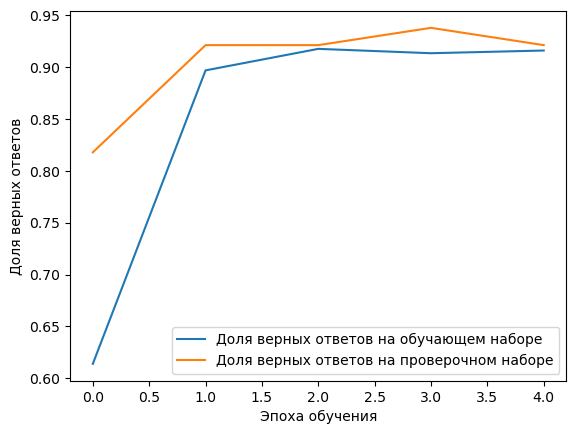

In [162]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Сеть LSTM

In [163]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(8, activation='softmax'))

In [164]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [165]:
history_lstm = model_lstm.fit(X_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/10
64/64 [==============================] - 6s 46ms/step - loss: 1.8493 - accuracy: 0.6070 - val_loss: 1.4404 - val_accuracy: 0.7344
Epoch 2/10
64/64 [==============================] - 3s 39ms/step - loss: 1.0912 - accuracy: 0.7306 - val_loss: 0.7147 - val_accuracy: 0.7789
Epoch 3/10
64/64 [==============================] - 2s 35ms/step - loss: 0.5914 - accuracy: 0.8285 - val_loss: 0.4346 - val_accuracy: 0.8978
Epoch 4/10
64/64 [==============================] - 2s 37ms/step - loss: 0.3885 - accuracy: 0.9042 - val_loss: 0.3096 - val_accuracy: 0.9156
Epoch 5/10
64/64 [==============================] - 2s 38ms/step - loss: 0.2848 - accuracy: 0.9160 - val_loss: 0.2255 - val_accuracy: 0.9211
Epoch 6/10
64/64 [==============================] - 2s 38ms/step - loss: 0.2455 - accuracy: 0.9159 - val_loss: 0.2014 - val_accuracy: 0.9211
Epoch 7/10
64/64 [==============================] - 3s 39ms/step - loss: 0.2285 - accuracy: 0.9148 - val_loss: 0.1892 - val_accuracy: 0.9233
Epoch 8/10
64

### Смотрим переобучение

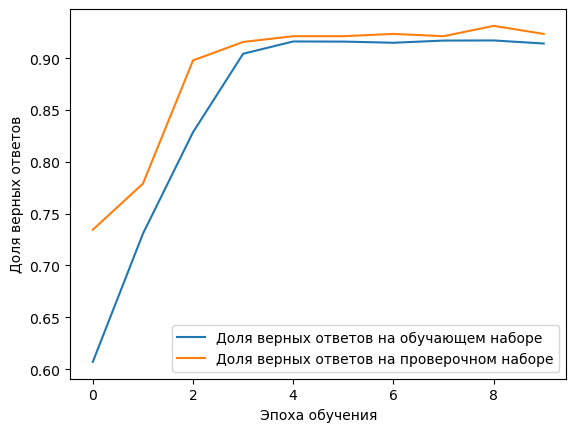

In [166]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Сеть GRU

In [167]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(32))
model_gru.add(Dense(8, activation='softmax'))

In [168]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [169]:
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 32)           320000    
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
Total params: 326,600
Trainable params: 326,600
Non-trainable params: 0
_________________________________________________________________


In [170]:
history_gru = model_gru.fit(X_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/10
64/64 [==============================] - 6s 51ms/step - loss: 1.7354 - accuracy: 0.6412 - val_loss: 1.1168 - val_accuracy: 0.7278
Epoch 2/10
64/64 [==============================] - 2s 39ms/step - loss: 0.7326 - accuracy: 0.7889 - val_loss: 0.4446 - val_accuracy: 0.8444
Epoch 3/10
64/64 [==============================] - 3s 44ms/step - loss: 0.3914 - accuracy: 0.8974 - val_loss: 0.2942 - val_accuracy: 0.9211
Epoch 4/10
64/64 [==============================] - 3s 49ms/step - loss: 0.2844 - accuracy: 0.9183 - val_loss: 0.2203 - val_accuracy: 0.9233
Epoch 5/10
64/64 [==============================] - 3s 48ms/step - loss: 0.2364 - accuracy: 0.9131 - val_loss: 0.1910 - val_accuracy: 0.9233
Epoch 6/10
64/64 [==============================] - 3s 43ms/step - loss: 0.2214 - accuracy: 0.9169 - val_loss: 0.1764 - val_accuracy: 0.9211
Epoch 7/10
64/64 [==============================] - 3s 41ms/step - loss: 0.2136 - accuracy: 0.9146 - val_loss: 0.1745 - val_accuracy: 0.9233
Epoch 8/10
64

### Смотрим переобучение

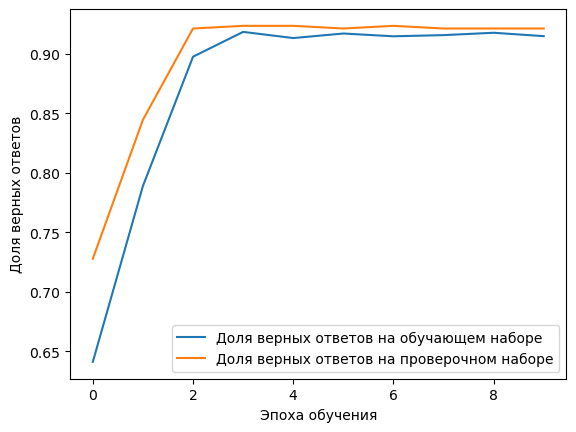

In [171]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Свёрточная сеть

In [172]:
model_cnn.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 4ms/step - loss: 0.1880 - accuracy: 0.9240


[0.18800990283489227, 0.9240000247955322]

### Сеть LSTM

In [173]:
model_lstm.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 1s 8ms/step - loss: 0.1925 - accuracy: 0.9140


[0.19246947765350342, 0.9139999747276306]

### Сеть GRU

In [174]:
model_gru.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 1s 9ms/step - loss: 0.1909 - accuracy: 0.9240


[0.19090227782726288, 0.9240000247955322]

### Проверка документа на фразе

In [175]:
#!pip install python-docx
from docx import Document

In [183]:
directory = 'hackaton_2023_01/task_3/output_decrees/docx/'
series = []
filesText = []

#for fileIndex in range():
#    name = str(fileIndex) + '.docx'
print("Введите название файла: ")

name = str(input())

def file(name):
    

    fileText = ''

    document = Document(directory + name)
    for paragraph in document.paragraphs:
        fileText += paragraph.text + '\n'
    print(fileText)
    filesText.append(fileText)

    return fileText

fileText = file(name)

Введите название файла: 


 10.docx



Отдел тестирования Департамента разработки


Информационное сообщение

В связи с окончанием проекта "Внедрение системы знаний" поручаю обеспечить выполнение задач:
1). Признать утратившими силу следующие организационно-распорядительные документы:
приказ Генерального директора от 09.07.2021 N 398.
Выполнить данное поручение до 20 ноя 18.

	○ дополнить пункт 2.4.1.3 приложением N 61 (прилагается).
Ответственным за контролем над исполнением вышеизложенного поручения назначить специалиста по информационной безопасности Поварихина Владимира. Привести вышеизложенное поручение в исполнение к 05.01.2016.

	○ Дополнить новым подпунктом 10.6 следующего содержания:
"10.6. Осуществление контроля качества предоставления государственных услуг и обеспечения их доступности по линии безопасности дорожного движения.". Приступить к исполнению поручения до 21 июня 2015 г..
Ответственность за исполнение задачи возложить на Контент менеджера Хромеца Манего.

		a) Внести изменения в ОРД согласно прилагаемом

In [184]:
fileText

'\nОтдел тестирования Департамента разработки\n\n\nИнформационное сообщение\n\nВ связи с окончанием проекта "Внедрение системы знаний" поручаю обеспечить выполнение задач:\n1). Признать утратившими силу следующие организационно-распорядительные документы:\nприказ Генерального директора от 09.07.2021 N 398.\nВыполнить данное поручение до 20 ноя 18.\n\n\t○ дополнить пункт 2.4.1.3 приложением N 61 (прилагается).\nОтветственным за контролем над исполнением вышеизложенного поручения назначить специалиста по информационной безопасности Поварихина Владимира. Привести вышеизложенное поручение в исполнение к 05.01.2016.\n\n\t○ Дополнить новым подпунктом 10.6 следующего содержания:\n"10.6. Осуществление контроля качества предоставления государственных услуг и обеспечения их доступности по линии безопасности дорожного движения.". Приступить к исполнению поручения до 21 июня 2015 г..\nОтветственность за исполнение задачи возложить на Контент менеджера Хромеца Манего.\n\n\t\ta) Внести изменения в О

# Векторизация текста

In [185]:
sequence = tokenizer.texts_to_sequences([fileText])

In [186]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [187]:
result = model_cnn.predict(data)

1/1 [==============================] - 0s 35ms/step


In [188]:
np.round(result, 3)

array([[0.483, 0.018, 0.014, 0.07 , 0.024, 0.005, 0.364, 0.023]],
      dtype=float32)

In [182]:
classes_dep

{'Служба ИТ': 1,
 'Отдел архитектуры': 2,
 'Отдел проектирования': 3,
 'Бухгалтерия': 4,
 'Отдел эксплуатации': 5,
 'Отдел тестирования': 6,
 'Отдел разработки систем': 7,
 'Административно-хозяйственный отдел': 8}

### Находим уникальные значения департаментов.

In [ ]:
departments_set = set(DEPARTMENTS)
departments_Unique_list = list(departments_set)
departments_Unique_list

### Строим однонаправленный граф.

In [ ]:
DG = nx.DiGraph()


DG.add_edge('ООО "Мегасофт"', departments_Unique_list[0]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[1]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[2]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[3]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[4]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[5]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[6]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[7]) 

nx.draw(DG, with_labels=True, font_weight='bold')

### Создаём мешок слов

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results